In [1]:
%matplotlib inline
import argparse

import matplotlib.pyplot as plt
import pandas as pd
#from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

import flax.linen as nn
import haiku as hk
import jax
from jax import device_put, random
import jax.numpy as jnp

import numpyro
from numpyro.contrib.module import flax_module, haiku_module
import numpyro.distributions as dist
from numpyro.infer import SVI, TraceMeanField_ELBO


/home/icarlos/Anakonda/envs/rapids-21.10/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/home/icarlos/Anakonda/envs/rapids-21.10/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '



# Example: ProdLDA with Flax and Haiku

In this example, we will follow [1] to implement the ProdLDA topic model from
Autoencoding Variational Inference For Topic Models by Akash Srivastava and Charles
Sutton [2]. This model returns consistently better topics than vanilla LDA and trains
much more quickly. Furthermore, it does not require a custom inference algorithm that
relies on complex mathematical derivations. This example also serves as an
introduction to Flax and Haiku modules in NumPyro.

Note that unlike [1, 2], this implementation uses a Dirichlet prior directly rather
than approximating it with a softmax-normal distribution.

For the interested reader, a nice extension of this model is the CombinedTM model [3]
which utilizes a pre-trained sentence transformer (like https://www.sbert.net/) to
generate a better representation of the encoded latent vector.

**References:**
    1. http://pyro.ai/examples/prodlda.html
    2. Akash Srivastava, & Charles Sutton. (2017). Autoencoding Variational Inference
       For Topic Models.
    3. Federico Bianchi, Silvia Terragni, and Dirk Hovy (2021), "Pre-training is a Hot
       Topic: Contextualized Document Embeddings Improve Topic Coherence"
       (https://arxiv.org/abs/2004.03974)


In [2]:
#!pip install -q numpyro@git+https://github.com/pyro-ppl/numpyro

In [3]:
#!pip install flax
#!pip install dm-haiku

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
class HaikuEncoder:
    def __init__(self, vocab_size, num_topics, hidden, dropout_rate):
        self._vocab_size = vocab_size
        self._num_topics = num_topics
        self._hidden = hidden
        self._dropout_rate = dropout_rate

    def __call__(self, inputs, is_training):
        dropout_rate = self._dropout_rate if is_training else 0.0

        h = jax.nn.softplus(hk.Linear(self._hidden)(inputs))
        h = jax.nn.softplus(hk.Linear(self._hidden)(h))
        h = hk.dropout(hk.next_rng_key(), dropout_rate, h)
        h = hk.Linear(self._num_topics)(h)

        # NB: here we set `create_scale=False` and `create_offset=False` to reduce
        # the number of learning parameters
        log_concentration = hk.BatchNorm(
            create_scale=False, create_offset=False, decay_rate=0.9
        )(h, is_training)
        return jnp.exp(log_concentration)


class HaikuDecoder:
    def __init__(self, vocab_size, dropout_rate):
        self._vocab_size = vocab_size
        self._dropout_rate = dropout_rate

    def __call__(self, inputs, is_training):
        dropout_rate = self._dropout_rate if is_training else 0.0
        h = hk.dropout(hk.next_rng_key(), dropout_rate, inputs)
        h = hk.Linear(self._vocab_size, with_bias=False)(h)
        return hk.BatchNorm(create_scale=False, create_offset=False, decay_rate=0.9)(
            h, is_training
        )


class FlaxEncoder(nn.Module):
    vocab_size: int
    num_topics: int
    hidden: int
    dropout_rate: float

    @nn.compact
    def __call__(self, inputs, is_training):
        h = nn.softplus(nn.Dense(self.hidden)(inputs))
        h = nn.softplus(nn.Dense(self.hidden)(h))
        h = nn.Dropout(self.dropout_rate, deterministic=not is_training)(h)
        h = nn.Dense(self.num_topics)(h)

        log_concentration = nn.BatchNorm(
            use_bias=False,
            use_scale=False,
            momentum=0.9,
            use_running_average=not is_training,
        )(h)
        return jnp.exp(log_concentration)

class FlaxDecoder(nn.Module):
    vocab_size: int
    dropout_rate: float

    @nn.compact
    def __call__(self, inputs, is_training):
        h = nn.Dropout(self.dropout_rate, deterministic=not is_training)(inputs)
        h = nn.Dense(self.vocab_size, use_bias=False)(h)
        return nn.BatchNorm(
            use_bias=False,
            use_scale=False,
            momentum=0.9,
            use_running_average=not is_training,
        )(h)


In [29]:
def model(docs, hyperparams, is_training=False, nn_framework="flax"):
    if nn_framework == "flax":
        decoder = flax_module(
            "decoder",
            FlaxDecoder(hyperparams["vocab_size"], hyperparams["dropout_rate"]),
            input_shape=(1, hyperparams["num_topics"]),
            # ensure PRNGKey is made available to dropout layers
            apply_rng=["dropout"],
            # indicate mutable state due to BatchNorm layers
            mutable=["batch_stats"],
            # to ensure proper initialisation of BatchNorm we must
            # initialise with is_training=True
            is_training=True,
        )
    elif nn_framework == "haiku":
        decoder = haiku_module(
            "decoder",
            # use `transform_with_state` for BatchNorm
            hk.transform_with_state(
                HaikuDecoder(hyperparams["vocab_size"], hyperparams["dropout_rate"])
            ),
            input_shape=(1, hyperparams["num_topics"]),
            apply_rng=True,
            # to ensure proper initialisation of BatchNorm we must
            # initialise with is_training=True
            is_training=True,
        )
    else:
        raise ValueError(f"Invalid choice {nn_framework} for argument nn_framework")

    with numpyro.plate(
        "documents", docs.shape[0], subsample_size=hyperparams["batch_size"]
    ):
        batch_docs = numpyro.subsample(docs, event_dim=1)
        theta = numpyro.sample(
            "theta", dist.Dirichlet(jnp.ones(hyperparams["num_topics"]))
        )

        if nn_framework == "flax":
            logits = decoder(theta, is_training, rngs={"dropout": numpyro.prng_key()})
        elif nn_framework == "haiku":
            logits = decoder(numpyro.prng_key(), theta, is_training)

        total_count = batch_docs.sum(-1)
        numpyro.sample(
            "obs", dist.Multinomial(total_count, logits=logits), obs=batch_docs
        )


def guide(docs, hyperparams, is_training=False, nn_framework="flax"):
    if nn_framework == "flax":
        encoder = flax_module(
            "encoder",
            FlaxEncoder(
                hyperparams["vocab_size"],
                hyperparams["num_topics"],
                hyperparams["hidden"],
                hyperparams["dropout_rate"],
            ),
            input_shape=(1, hyperparams["vocab_size"]),
            # ensure PRNGKey is made available to dropout layers
            apply_rng=["dropout"],
            # indicate mutable state due to BatchNorm layers
            mutable=["batch_stats"],
            # to ensure proper initialisation of BatchNorm we must
            # initialise with is_training=True
            is_training=True,
        )
    elif nn_framework == "haiku":
        encoder = haiku_module(
            "encoder",
            # use `transform_with_state` for BatchNorm
            hk.transform_with_state(
                HaikuEncoder(
                    hyperparams["vocab_size"],
                    hyperparams["num_topics"],
                    hyperparams["hidden"],
                    hyperparams["dropout_rate"],
                )
            ),
            input_shape=(1, hyperparams["vocab_size"]),
            apply_rng=True,
            # to ensure proper initialisation of BatchNorm we must
            # initialise with is_training=True
            is_training=True,
        )
    else:
        raise ValueError(f"Invalid choice {nn_framework} for argument nn_framework")

    with numpyro.plate(
        "documents", docs.shape[0], subsample_size=hyperparams["batch_size"]
    ):
        batch_docs = numpyro.subsample(docs, event_dim=1)

        if nn_framework == "flax":
            concentration = encoder(
                batch_docs, is_training, rngs={"dropout": numpyro.prng_key()}
            )
        elif nn_framework == "haiku":
            concentration = encoder(numpyro.prng_key(), batch_docs, is_training)

        numpyro.sample("theta", dist.Dirichlet(concentration))


def load_data():
    news = pd.read_csv("data_clean.csv")
    vectorizer = CountVectorizer(max_df=0.01, min_df=10)
    #docs = jnp.array(vectorizer.fit_transform(news["text"][13027:15173]).toarray())
    docs = jnp.array(vectorizer.fit_transform(news["text"][:13027]).toarray())
    vocab = pd.DataFrame(columns=["word", "index"])
    vocab["word"] = vectorizer.get_feature_names()
    vocab["index"] = vocab.index

    return docs, vocab


def run_inference(docs, args):
    rng_key = random.PRNGKey(0)
    docs = device_put(docs)

    hyperparams = dict(
        vocab_size=docs.shape[1],
        num_topics=12,
        hidden=5000,
        dropout_rate=0.4,
        batch_size=64,
    )

    optimizer = numpyro.optim.Adam(5e-6)
    svi = SVI(model, guide, optimizer, loss=TraceMeanField_ELBO(num_particles=1))

    return svi.run(
        rng_key,
        50000, #samples
        docs,
        hyperparams,
        is_training=True,
        progress_bar=True,
        nn_framework="flax",
    )


def plot_word_cloud(b, ax, vocab, n):
    indices = jnp.argsort(b)[::-1]
    top20 = indices[:20]
    df = pd.DataFrame(top20, columns=["index"])
    words = pd.merge(df, vocab[["index", "word"]], how="left", on="index")[
        "word"
    ].values.tolist()
    sizes = b[top20].tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    wc = WordCloud(background_color="white", width=800, height=600)
    wc = wc.generate_from_frequencies(freqs)
    ax.set_title(f"Topic {n + 1}")
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")

def save_data_plot(b,vocab):
    indices = jnp.argsort(b)[::-1]
    top20 = indices[:20]
    df = pd.DataFrame(top20, columns=["index"])
    words = pd.merge(df, vocab[["index", "word"]], how="left", on="index")[
        "word"
    ].values.tolist()
    sizes = b[top20].tolist()
    freqs = {words[i]: sizes[i] for i in range(len(words))}
    dict_freqs = pd.DataFrame(freqs.items(),columns =['Concept', 'value'])
    return dict_freqs
    
    
def main(args):
    docs, vocab = load_data()
    print(f"Dictionary size: {len(vocab)}")
    print(f"Corpus size: {docs.shape}")


    svi_result = run_inference(docs, args)

    if args.nn_framework == "flax":
        beta = svi_result.params["decoder$params"]["Dense_0"]["kernel"]
    elif args.nn_framework == "haiku":
        beta = svi_result.params["decoder$params"]["linear"]["w"]

    beta = jax.nn.softmax(beta)

    # the number of plots depends on the chosen number of topics.
    # add 2 to num topics to ensure we create a row for any remainder after division
    
    num_topics=12
    nrows = (num_topics + 2) // 3
    fig, axs = plt.subplots(nrows, 3, figsize=(14, 3 + 3 * nrows))
    axs = axs.flatten()
    

    for n in range(beta.shape[0]):
        plot_word_cloud(beta[n], axs[n], vocab, n)

    for n in range(beta.shape[0]):
        results = save_data_plot(beta[n], vocab)
        results.to_csv(f"./data_topics/dict_freqs_top20_topic_{n}.csv")
        
    # hide any unused axes
    for i in range(n, len(axs)):
        axs[i].axis("off")

    fig.savefig("/data_topics/wordclouds-2020-11.png")



In [30]:
#!pip install easydict

In [31]:
#algunos parametros hay que modificarlos manual en las funciones
import easydict
args = easydict.EasyDict({
        "n":30,
        "t":15,
        "num_topics":12,
        "dp": False,
        "disable-progbar":False,
        "device":"cpu",
        "nn_framework":"flax"

})

/home/icarlos/Anakonda/envs/rapids-21.10/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Dictionary size: 258
Corpus size: (1000, 258)


100%|██████████| 200/200 [00:27<00:00,  7.38it/s, init loss: 34375.6875, avg. loss [191-200]: 20021.3574]


dict_items([('timoneles', 0.00797072984278202), ('violación', 0.006962121929973364), ('fortaleza', 0.0065545630641281605), ('existencia', 0.0064404914155602455), ('continuó', 0.006318802945315838), ('comisiones', 0.006256898399442434), ('ohiggins', 0.006225110962986946), ('alcohol', 0.0060981884598731995), ('regla', 0.005858083721250296), ('mostraron', 0.005842857528477907), ('extranjeros', 0.005818589590489864), ('dichas', 0.0058093564584851265), ('batalla', 0.005733783356845379), ('aumentado', 0.005730792414397001), ('83', 0.005638457834720612), ('hábiles', 0.005636245012283325), ('jugando', 0.005635831505060196), ('nombrar', 0.005635306239128113), ('modificación', 0.005599139258265495), ('empezar', 0.005597598850727081)])
dict_items([('mixta', 0.007655383553355932), ('usando', 0.006635509897023439), ('consideran', 0.006477701477706432), ('tomaron', 0.0064546833746135235), ('obligatorio', 0.006302947178483009), ('públicamente', 0.006270148791372776), ('mencionó', 0.006205710116773844

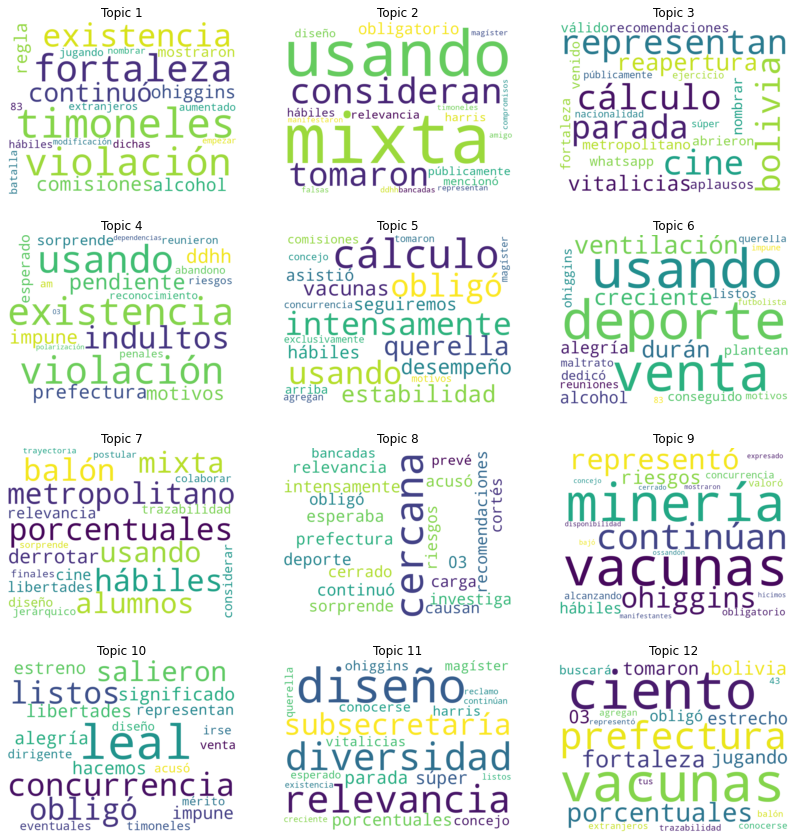

In [32]:
numpyro.set_platform(args.device)

main(args)

In [33]:
datatest  = pd.read_csv("data_topics/dict_freqs_top20_topic_0.csv")

In [35]:
#Conceptos más frecuentes del tópico 1
datatest["Concept"]

0        timoneles
1        violación
2        fortaleza
3       existencia
4         continuó
5       comisiones
6         ohiggins
7          alcohol
8            regla
9        mostraron
10     extranjeros
11          dichas
12         batalla
13       aumentado
14              83
15         hábiles
16         jugando
17         nombrar
18    modificación
19         empezar
Name: Concept, dtype: object